*Ying Chan*

# Executive Summary

Long Short Term Memory (LSTM) models are powerful extensions upon recurrent neural networks (RNNs) that can incorporate long term memory. RNNs are yet a time series extension of traditional neural networks to capture dependence across time.

By leveraging a chain of memory cells much like that of a human brain, LSTMs are capable of selectively storing information in its memory for long periods of time, and can selectively forget information if data deems it to be not useful in its next prediction. By using LSTMs, we are able to capture market trends, mimicking memories of investors in the market and capturing its sentiment over time.

Using a 20 step historical memory LSTM model, we were able to generate an accuracy in the magnitude of around 82% (i.e. correctly predicting an upward or downward move). Based on a pro-rated daily return of the 20 day forward SPY return to test the performance of our model, we were able to outperform the "SPY buy and hold strategy", via both a long-short and long-only strategy over a test period of 349 periods (the last 10% of our data). The mean model (done by calculating the mean return of all training samples) which predicted all test samples as an up market, performed with roughly 70% accuracy.

Model                    | Accuracy | Strategy | Cumulative Return
------------------------ |---------:| ----------|-------------------:|
LSTM                     |82%     |Long Short|42.0%
LSTM                     |82%     |Long Only|31.6%
Mean |~70%     |Buy and Hold|21.5%

# Introduction to LSTMs

## Neural networks and recurrent neural networks

Neurons underpin the structure of a neural network. Each neuron accepts a dimension of inputs, and via an activation function (think of it as a binary output 0 or 1 though it can be a smooth differentiable equation), it determines whether it should fire a response or not fire a response. With enough neurons and layers, it is able to model complex functions outside of a standard linear framework. The weights are optimized such that the difference between the output from the neural network and the value we are trying to predict is minimized. This is done through a method known as backpropagation, which is simply a reverse direction chain rule of differentiation to update the weights. 

A extension of a neural network would be a chain of neurons lined up in a sequence, creating what is known as a recurrent neural network (RNN). A time series of x variables (the inputs) passing through a simple activation function (for example the tanh function), and the cell outputs the value h. The h value is then concatenated with the next time series input value x and passes through yet another activation function.

With this chained approach, RNN allows for predictions of sequences, or predictions that are based on sequences of information, unlike traditonal neural networks that capture only point-in-time information.

However, there are shortcomings of vanilla RNNs, and it is their inability to capture information that are many time steps away. The information gets lost as the sequence progresses. Here is where LSTMs come into play.

## LSTMs

Long Short Term Memory (LSTM) models have four layers of neural networks instead of one, with each layer acting in a slightly different way. There are four activation layers in an LSTM memory cell, namely $a^t$, $i^t$, $f^t$ and $o^t$. There exists a cell state that is carried along each cell much like a conveyor belt, carrying information that could potentially be many cells back. This "memory" cell is known as $c^t$. The previous cell state would therefore be $c^{t-1}$.

$a^t$ represents the activation on the information that is stored in the memory cell state in the previous cell. It is the new cell's information.

$i^t$ represents the activation on the current timestep's inputs. It controls how much of $a^t$ do we add to the new cell state. 

$f^t$ represents the forget gate activation. It controls how much of the old cell state $c^t$ should we forget and remember.

$o^t$ represents the output gate, and controls how much of the updated $c^t$ is outputed as $h^t$.

Each of the above "activation functions" uses information from the inputs at time t ($x^t$) along with information from the output in the previous cell state ($h^{t-1}$), each with their own weights ($W$ and $U$ respectively), plus a bias term. 

$$a^t = \tanh(W_cx^t + U_ch^{t-1}) $$
$$i^t = \sigma(W_ix^t + U_ih^{t-1}) $$
$$f^t = \sigma(W_fx^t + U_fh^{t-1}) $$
$$o^t = \sigma(W_ox^t + U_oh^{t-1}) $$

The new timestep's cell state $c^t$ is then updated by $c^t = i^t \odot a^t + f^t \odot c^{t-1}$. The first term captures how much information it should input on the new cell state, while the second term captures how much information it should keep from the old cell state. This cell state is then passed onto the next cell for more updates much like a conveyor belt.

$h^t$ is then $h^t = o^t \odot \tanh(c^t)$, which is sent to the next cell and outputed as the output for that cell. 

The process repeats. 

Long story short, LSTMs basically allow for remembering information that occured in many cell states back, a feature that vanilla RNNs cannot. It is also able to selectively remember information by forgetting information it deems unnecessary in the prediction, and the selectivity in memory is trained based on the data. This strength in the LSTM model, we believe, can be leveraged to analyze and model financial time series data, as it can capture not only the state of the current information, but aslo the trend of this data. For example, it is helpful in looking at trends in technical analysis, as well as remembering earning reports that occured a few quarters ago.

We will leverage this long term memory capability in LSTMs for modeling our SPY returns. 

# Benchmark model

All modeling procedures start with a benchmark model, much like a dry run, such that subsequent improvements to the model can be measured and determined.

We start by importing a few libraries and the prepared dataset (along with the new feature engineered variables) into Python below. We will also remove the date variable in our training as this information has already been captured in our feature engineering step in R. We will be using the Keras library, which leverages a TensorFlow backend. 

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import math
import numpy as np
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras import optimizers

dataset = pd.read_csv('train.csv', index_col=0)
dataset = dataset.drop('date_', 1)

np.random.seed(3)

The input dataset LSTM models take will be in the form of a 3D matrix with dimensions [number of observations x number of time steps x number of variables]. Th number of timesteps is the number of steps the model will look back to obtain information about the sequeneces of each variable. We will discuss this in more detail in the section: Final Model - adding LSTM timesteps. 

Since our data set is in the form [number of observations x number of variables], we will be using a sliding window to slice our data, with a window of length equal to the number of time steps. For example, for timestep = T, the first observation will be the first T records, with the total number of variables as a 2D matrix. The second will be from the second record to the T+1 record, agin with all the variables. We bundle these sliding windows into a 3D matrix with the above dimensions.

We will start by using a timestep of 1 for the benchmark case.

In [42]:
var_dim = dataset.shape[1]
no_var = dataset.shape[1] - 1

timesteps = 1
no_obs = dataset.shape[0] - timesteps + 1

input_slice = np.empty((timesteps, var_dim))

for i in range(0, no_obs):
    add_slice= np.empty((1, timesteps, var_dim))
    add_slice = dataset[i:i+timesteps]
    input_slice = np.dstack((input_slice,add_slice))
    
input_slice = np.delete(input_slice, (0), axis=2)
input_slice =input_slice.swapaxes(0,2)
input_slice =input_slice.swapaxes(1,2)

Once we have the 3D matrix of all the data, we will separate the data into the training sample, the cross validation sample and the testing sample. The testing sample will be the last 10% of the data. It is curucial that we do not shuffle the data to obtain our training or validation sample, as we do not have any information about the future in a financial setting. The cross validation sample is used for tuning our hyperparameters as we will see in later sections. 

Out of the remaining sample, we will subset into 80% training and 20% for cross validation. 

In [43]:
train_size = int(no_obs * 0.9)
test_size = no_obs - train_size

train = input_slice[:train_size]
test = input_slice[train_size:]

trainX = train[:,:,1:]
trainY = train[:,0:1,0:1]
testX = test[:,:,1:]
testY = test[:,0:1,0:1]
trainY = trainY.reshape(trainY.shape[0], 1)
testY = testY.reshape(testY.shape[0], 1)

print trainX.shape
print trainY.shape
print testX.shape
print testY.shape


(3132, 1, 120)
(3132, 1)
(349, 1, 120)
(349, 1)


We start by creating our LSTM with an arbitrary number of neurons. In our dry run of creating the model, we will start with 4. We will investigate in our sections below how this would affect model performance. The number of neurons determine how many weights it will have to train, and the more neurons the more complex the relationship it can model. However, increasing too many neurons will make the model difficult to train.


In [44]:
##baseline
model = Sequential()
optimizers.Adam(clipnorm=1)

model.add(LSTM(4, return_sequences=False, input_shape=(timesteps, no_var)))  
model.add(Activation('sigmoid'))
model.add(Dense(1)) 

model.compile(loss='mse', optimizer='adam')

model.fit(trainX, trainY, epochs=10, batch_size=10, verbose=0,  validation_split=0.2)

For assessing our models, as we will see in more detail later, we will be using the mean squared error (MSE). This is defined as the mean squared difference between the predicted variable and the actual variable from the validation sample. This will be our validation loss measure. For the testing sample, we will look at the root mean squared error (RMSE), which is the square root of the MSE metric. This gives an idea of how far away our predictions are. 

Below, we have our starting RMSE of 6.15%. This is quite high, given SPY returns are not that high over a 20 day time period. We will improve our model by tuning each of the parameters in our model. 

In [45]:
testPredict = model.predict(testX)

rmse = math.sqrt(mean_squared_error(testY, testPredict))
print rmse
#predicted all the same values

0.0615402184069


# Data preparation: normalization

In training a machine learning model, there are many ways in which the model can be improved, from both tuning hyperparameters to initializing the weights properly to ensure that the model is trained well, to scaling the input data.

We start by investigating the necessity of normalization, also known as scaling. Scaling is typically done for variables that have a wide range of level values and are of various units. Scaling however, will normalize these variables independently into a set range and distributed in a set distribution, such that weights are found appropriately and quickly. We found that for our dataset, the standard normal scaler improve results the best (versus a linear 0 to 1 MinMax scaler).

Normalization | Weights Initializer |Neurons |Validation Loss | Test Set RMSE 
------------- |-------------| -----|-----| 
Standard|Xavier|500/250|0.0032|0.026
MinMax|Xavier|500/250|0.0016|0.0352

# Model hyperparameters

## Initialization of weights

Through investigation into the poor performance of the model, we noticed that a better intializer of the weights (i.e. starting values of the weights and biases) helped significantly. A popular choice is the Xavier initializer, which is a popular normally distributed initial weights for each of the weights in the activation functions in the neural network. Having good initial starting weights help the weights to move towards its local minimums quicker, without getting "stuck" in its current state when updated, a symptom known as the zero gradient problem.

## Activation functions

Neural networks depend on individual neurons firing information from one neuron to the next. The activaiton function determines the level of strength the signal is fired. Smoother functions like the sigmoid have a softer impact, which may tend to produce better results if they are trained properly, but are harder to train. Stronger activation functions like the ReLu activation function (also known as a softsign), is less affected by the zero gradients problem.

With complex models like ours, we noticed that the ReLu activation functions were easily trained without the problem of zero gradients. The performance against the sigmoid function was comparable. 

Activation | Neuron Pairs |Validation Loss (or MSE) | Test Set RMSE 
------------- | -----| -----|-----| -----|
ReLu|250/100| 0.004|0.0284
Sigmoid| 250/100| 0.0032|0.028

## Model complexity

The number of neurons and the number of layers in the LSTM network model determines the level of complexity the model is capable of learning. Adding neurons and layers to the model increases capacity of the model to deal with complex situations, but also increases the number of parameters to estimate, which could lead to deterioration of the model performance. 

We investigated a combination of various complexities of the model, and based on validation loss, we determined that a two layer LSTM created sufficient complexity in the model to capture patterns in the data, and determined that roughly 200 neurons in the first hidden layer followed by a 100 neurons in the second hidden layer produced the best results. We have also included the accuracy metric in the following table, which is the percentage of correct predictions (i.e. correctly predicting the market is up or when it is down) after converting to a binary prediction. 

We will cover in more detail relating to the accuracy measure on the test set in a later section. We would like to note that although we have pointed out the test set RMSE and test set accuracy measures here, we will only be using the validation loss in determining the model complexity to use. 

We have also determined that a batch size of 20 (along with some other batch sizes) to be suitable for our data. The batch size indicates how many records are used before the weights are updated. A low batch size creates large fluctuations in the validation loss functions, which could inhibit us from determining which model works best. 

 Neurons in Layer 1 | Neurons in Layer 2 | Neurons in Layer 3 | Validation Loss | Test Set RMSE | Accuracy
------------- |-------------| -----| -----|-----|
150|0|0|0.0127|0.0733| 0.51
500|250|0|0.004|0.0385| 0.49
250|100|0|0.004|0.0284| 0.67
100|40|0|0.004|0.0318|0.70
50|10|0|0.005|0.0327|0.64
250|100|20|0.0027|0.047|0.53

# Preventing overfitting: dropouts and early stopping

Dropouts are used in recurrent neural network models (including LSTMs) to adjust for overfitting. Dropouts are randomly selected percentage of neurons or inputs (depending on where the dropout is placed) that are ignored when performing the model fitting. This helps in reducing overfitting as those information would be "lost" and not fitted perfectly with the training data.

A typical dropout percentage is 20%. The dropout mechanism is outlined in Dropout: A Simple Way to Prevent Neural Networks from Overfitting 2014 [1]:http://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf.

Dropouts are recommended on both the hidden layers as well as the input layers. Due to the act of dropping variables randomly, the learning rate can also increased by a factor of 10 to assist training. The learning rate is also a model hyperparameter that is set to determine how fast the model learns the weights. Setting a high learning rate increases the speed at which the model is trained, however, could potentially cause weights that overshoot and hard to converge. However, by implementing a dropout, the learning rate can be increased to improve training time. 

By adding in the input dropout along side an increase in learning rate, we observe and improvement in the validation loss slightly.

Another method of preventing overfitting in neural network training models would be to use early stopping. Early stopping refers to stopping the training when the validation loss stops declining or improving. 

It was noticed that an early stopping of training for our dataset at 50 epochs to be optimal. The number of epochs is the number of times the entire dataset is passed through the model to train and update the weights. 

epochs | Learning Rate | Input Dropout | Hidden Dropout | Validation Loss | Test Set RMSE | Accuracy
------------- |------------- |------------- |-------------| -----| -----|-----|
100|0.01 | 20% | 20% | 0.0019| 0.0288| 54%
50|0.01 | 0% | 20% | 0.0017| 0.0282 | 62%
50|0.001 | 0% | 20% | 0.0017| 0.0278 | 65%
50|0.01 | 20% | 20% | 0.0016| 0.0266| 65%

Below shows the code that is executed with the above modifications and improvements to the model iteratively. The structure of the code is similar to that outlined in our benchmark model. 

In [100]:
#second run
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

from sklearn.preprocessing import StandardScaler
#scaler = MinMaxScaler(feature_range=(0,1))
scaler = StandardScaler()

dataset = pd.read_csv('train.csv', index_col=0)
dataset = dataset.drop('date_', 1)

var_dim = dataset.shape[1]
no_var = dataset.shape[1] - 1

timesteps = 1

no_obs = dataset.shape[0] - timesteps + 1

datasetX = dataset.drop('fwdRet20D', 1)
datasetY = dataset[dataset.columns[0]]

datasetX = scaler.fit_transform(datasetX)

input_slice = np.empty((timesteps, no_var))

for i in range(0, no_obs):
    add_slice= np.empty((1, timesteps, no_var))
    add_slice = datasetX[i:i+timesteps]
    input_slice = np.dstack((input_slice,add_slice))

input_slice = np.delete(input_slice, (0), axis=2)    
    
input_slice =input_slice.swapaxes(0,2)
input_slice =input_slice.swapaxes(1,2)

train_size = int(no_obs * 0.9)
test_size = no_obs - train_size

train = input_slice[:train_size]
test = input_slice[train_size:]

trainX = train
testX = test

trainY = datasetY[:train_size]
testY = datasetY[train_size:]

#trainX = train[:,:,1:]
#trainY = train[:,0:1,0:1]
#testX = test[:,:,1:]
#testY = test[:,0:1,0:1]
trainY = trainY.values.reshape(trainY.shape[0], 1)
testY = testY.values.reshape(testY.shape[0], 1)


In [101]:
from keras.layers import Dropout
from keras import initializers
initializers.glorot_normal(seed=3)
import tensorflow as tf
tf.set_random_seed(3)

optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0,clipnorm=1)
model = Sequential()
model.add(Dropout(0.2, input_shape=(timesteps, no_var)))
model.add(LSTM(250, return_sequences=True,
                kernel_initializer='glorot_normal', activation='relu'))  #100
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False,
                kernel_initializer='glorot_normal', activation='relu'))  #40
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(1, kernel_initializer='glorot_normal')) 

model.compile(loss='mse', optimizer='adam')

history = model.fit(trainX, trainY, epochs=25, batch_size=20, verbose=0,  validation_split=0.2)

# Intermediary model evaluation: errors and accuracy

We will be using the validation loss as a one of the indicators of the model performance. The below graph shows the performance of the model over each epoch. The validation loss is decreasing along-side the training loss, which is typical of a model that is fitting well. When the validation loss starts to plateau, we would perform an early stopping of the training to obtain a model with the best generalizability. 

We also observed a substantial improvement in the test RMSE compared to the initial benchmark.

We also looked at the accuracy of our prediction as a binary variable. The question can also be framed as a prediction of whether the SPY will go up or down in the next 20 days, as opposed to actually predicting the magnitude of the decline or rise. We will explore this topic in more detail in the subsequent section. 

The accuracy of the model is best represented as a confusion matrix, where the predictions of a down or up move in the market is shown as columns, while the actual movements which are shown as rows. We have used the sum of the accurate predictions in both up and down move as a measure of accuracy. 

In this iteration run, we observe a test accuracy of 65%. We noticed that a mean strategy (i.e. simply calculating the mean of all returns in the training sample), predicted the market with an accuracy of around 70% in the test set. An accuracy of 65% has room for improvement, which we will explore to improve in a subsequent section.

['loss', 'val_loss']


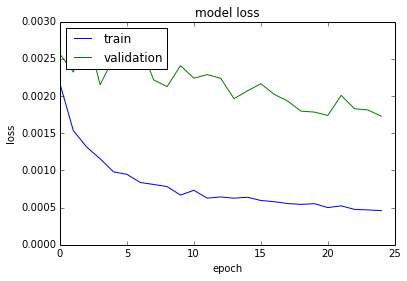

In [102]:
print(history.history.keys())

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

In [103]:
testPredict = model.predict(testX)
rmse = math.sqrt(mean_squared_error(testY, testPredict))
print rmse

0.0266548950291


In [104]:
from sklearn.metrics import confusion_matrix

testYbinary = np.empty(testY.shape[0])
testPredictbinary = np.empty(testY.shape[0])

for i in range(0,len(testY)):
    if testY[i] <0:
        testYbinary[i] = 0
    else:
        testYbinary[i] = 1
        
for i in range(0,len(testPredict)):
    if testPredict[i] <0:
        testPredictbinary[i] = 0
    else:
        testPredictbinary[i] = 1
   
#Print confusion matrix as percentages        
confusion_matrix(testYbinary, testPredictbinary)*1.0/testY.shape[0]

array([[ 0.15759312,  0.13467049],
       [ 0.20630372,  0.50143266]])

# Framing the problem as a classification model

The problem at hand was to investigate whether the SPY would be up or down in the next 20 days using this model. There are multiple ways in which we can attack this problem. One which we have addressed above involves predicting the 20 day return and minimizing the squared error, similar to a regression based model.

Another way we can frame this would be to treat this as a categorical binary model, as we may only be interested in predicting whether the market goes up or down, versus actually predicting the magnitude of the movement. 

Both methods of framing the problem has its advantage and disadvantages. The first method of minimizing the squared error allows us to capture the magnitude of the move in our model, allowing the model to differentiate between big up moves versus smaller moves. However, this method relies on the model to fit more information, hence harder to train. The second method reduces the time for the model to investigate how big of an up or down move it is. 

We use a binary cross entropy loss function (for binary predictors), and use a sigmoid activation function, as this bounds the prediction between 0 and 1. 

We will compare the two models (both on performance and variable importance) in our final model section below, where we will be tuning our last hyperparamter: timesteps. 

# Final model: adding LSTM timesteps

Timesteps is a crucial parameter in an LSTM model, as it is the main driver of the power it gives to an LSTM. It defines the maximum number of timelags that the model will look at for trends and signals to predict the final outcome. As shown before, LSTMs include gates for remembering and forgetting information, and the magnitude of how much to remember or forget is done through training.

In our example, we have tested a range of timesteps for our model, and was able to achieve a high validation accuracy  of up to 87% for 20 timesteps. The testing accuracy was around 80%. We observe similar performance for both the binary classification model as well as the mean squared error (MSE) model. 

When we increased the timesteps to 40, the performance started to degrade. This is most likely due to the fact that there are many more variables, requiring more neurons and layers. However, when we increased the neurons, it still struggled to perform. We believe this could be due to to too many variables and patterns to look at, confusing the model. 40 time steps is quite a long period of time, given that we are only looking at at the forward 20 day return in the SPY. Investors are most likely only interested in trends that happened over the past month of trading. 

We also noticed that the neuron pairs did not appear to affect the results significantly. This is most likely due to the fact that we have used dropouts and early stopping as mitigation for overfitting, as well as allowing for larger number of neurons to capture complicated relationships.

Based on the validation accuracy, our final binary candidate models would therefore be the 100/20 neuron pairs. For our mean squared error model, we would choose the 200/100 neuron pair. Note that we should not use the test RMSE or test accuracy in selecting our model. It is not surprising to see that the binary model required fewer neurons, as the imformation it is required to predict is less. 

Model | Neuron Pairs |LSTM Timesteps | Validation Accuracy or Loss | Test Set RMSE | Test Accuracy
---- |------------- |------------- |------------- |------------- |-------------|
Binary|20/10 |1|63%|n/a|62%
Binary|200/100 |1|62%|n/a|60%
Binary|200/100 |20|85%|n/a|81%
Binary|100/20 |20|87%|n/a|82%
Binary|50/10 |20|85%|n/a|79%
MSE|200/100|1| 0.0019|0.0266|65%
MSE|200/100|20| 0.0010|0.013|84%
MSE|100/20|20| 0.0017|0.0299|72%

## Final model performance breakdown

In the below confusion matrix, we explored the breakdown of the performance of our binary classification model in detail. It was able to predict a large portion of an up market as up, with only a very small prediction of it going down. For the down market scenario, it similarly predicted mostly a down market, by ratio of 19:9. This ratio was less pronounced compared to the up market move ratio. This is not surprising since it is difficult to foresee a down market movement!

Actual/Prediction | Predicted Down | Predicted Up 
---- |------------- |------------- |
Down Market| 19.7% |9.29%
Up Market |2.19%|63.7%


The performance of the mean squared error LSTM model was similar.

Actual/Prediction | Predicted Down | Predicted Up 
---- |------------- |------------- |
Down Market| 24.6% | 4.37%
Up Market |5.74%|60.11%

### Binary classification model with 20 timesteps LSTM model

Below shows the final code that was used for producing the results of our binary LSTM model.

In [3]:
# lstm timesteps with binary

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

dataset = pd.read_csv('train.csv', index_col=0)
dataset = dataset.drop('date_', 1)

var_dim = dataset.shape[1]
no_var = dataset.shape[1] - 1

timesteps = 20

no_obs = dataset.shape[0] - timesteps + 1

datasetX = dataset.drop('fwdRet20D', 1)
datasetY = dataset[dataset.columns[0]]

datasetX = scaler.fit_transform(datasetX)

input_slice = np.empty((timesteps, no_var))

for i in range(0, no_obs):
    add_slice= np.empty((1, timesteps, no_var))
    add_slice = datasetX[i:i+timesteps]
    input_slice = np.dstack((input_slice,add_slice))

input_slice = np.delete(input_slice, (0), axis=2)    
    
input_slice =input_slice.swapaxes(0,2)
input_slice =input_slice.swapaxes(1,2)

train_size = int(no_obs * 0.9)
test_size = no_obs - train_size

train = input_slice[:train_size]
test = input_slice[train_size:]

trainX = train
testX = test

trainY = datasetY[:train_size]
testY = datasetY[train_size:]

#trainX = train[:,:,1:]
#trainY = train[:,0:1,0:1]
#testX = test[:,:,1:]
#testY = test[:,0:1,0:1]
trainY = trainY.values.reshape(trainY.shape[0], 1)
testY = testY.values.reshape(testY.shape[0], 1)

In [14]:
from keras import initializers
initializers.glorot_normal(seed=3)
import tensorflow as tf
tf.set_random_seed(3)

trainYbinary = np.empty(trainY.shape[0])

for i in range(0,len(trainY)):
    if trainY[i] <0:
        trainYbinary[i] = 0
    else:
        trainYbinary[i] = 1

from keras.layers import Dropout

optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0,clipnorm=1)
model = Sequential()
model.add(Dropout(0.2, input_shape=(timesteps, no_var)))
model.add(LSTM(100, return_sequences=True,
                kernel_initializer='glorot_normal', activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(20, return_sequences=False,
                kernel_initializer='glorot_normal', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, kernel_initializer='glorot_normal', activation = 'sigmoid')) 

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(trainX, trainYbinary, epochs=10, batch_size=20, verbose=0,  validation_split=0.2)


Below shows the accuracy (training sample versus the validation sample) across epochs. We notice a strong increase in the training accuracy, however, once the validation accuracy appeared to plateau, we stopped the training to prevent overfitting. 

['acc', 'loss', 'val_acc', 'val_loss']


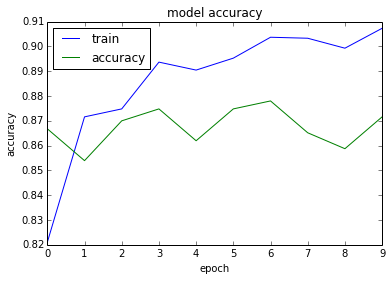

In [15]:
print(history.history.keys())

# summarize history for loss
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'accuracy'], loc='upper left')

In [16]:
from sklearn.metrics import confusion_matrix
testPredict = model.predict(testX)

rounded = [round(x[0]) for x in testPredict]

testYbinary = np.empty(testY.shape[0] - timesteps + 1)
for i in range(0,len(testY)-timesteps+1):
    if testY[i] <0:
        testYbinary[i] = 0
    else:
        testYbinary[i] = 1

#Print confusion matrix as percentages        
confusion_matrix(testYbinary, rounded)*1.0/testY.shape[0]

array([[ 0.19672131,  0.09289617],
       [ 0.02185792,  0.63661202]])

### Mean squared error with 20 timesteps LSTM model 

Below shows the final code that was used for the mean squared error LSTM model.

In [4]:
from keras.layers import Dropout
from keras import initializers
initializers.glorot_normal(seed=3)
import tensorflow as tf
tf.set_random_seed(3)

optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0,clipnorm=1)
model2 = Sequential()
model2.add(Dropout(0.2, input_shape=(timesteps, no_var)))
model2.add(LSTM(250, return_sequences=True,
                kernel_initializer='glorot_normal', activation='relu'))  #100
model2.add(Dropout(0.2))
model2.add(LSTM(100, return_sequences=False,
                kernel_initializer='glorot_normal', activation='relu'))  #40
model2.add(Dropout(0.2))
model2.add(Activation('relu'))
model2.add(Dense(1, kernel_initializer='glorot_normal')) 

model2.compile(loss='mse', optimizer='adam')

history = model2.fit(trainX, trainY, epochs=25, batch_size=20, verbose=0,  validation_split=0.2)

Below shows the training and validation loss across epochs. 

['loss', 'val_loss']


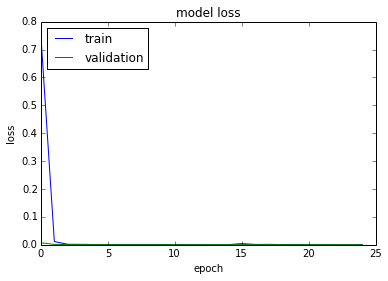

In [5]:
print(history.history.keys())

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

We achieved an RMSE of 0.013, which is yet another improvement over our intermediary model above. 

In [6]:
testPredict = model2.predict(testX)

testYcut = np.empty(testY.shape[0] - timesteps + 1)
for i in range(0,len(testY)-timesteps+1):
    testYcut[i] = testY[i]

rmse = math.sqrt(mean_squared_error(testYcut, testPredict))
print rmse

0.0130975164643


In [7]:
from sklearn.metrics import confusion_matrix

testYbinary = np.empty(testYcut.shape[0])
testPredictbinary2 = np.empty(testYcut.shape[0])

for i in range(0,len(testYcut)):
    if testY[i] <0:
        testYbinary[i] = 0
    else:
        testYbinary[i] = 1
        
for i in range(0,len(testPredict)):
    if testPredict[i] <0:
        testPredictbinary2[i] = 0
    else:
        testPredictbinary2[i] = 1
   
#Print confusion matrix as percentages        
confusion_matrix(testYbinary, testPredictbinary2)*1.0/testY.shape[0]

array([[ 0.24590164,  0.04371585],
       [ 0.05737705,  0.6010929 ]])

# Variable importance

As described in the introduction, the complexity of the weights in an LSTM memory cell, including the forget gates, input gates, activation gates as well as the output gates, creates much more dimensionality than an traditional neural networks. Existing literature has performed brief variable importance methodology analysis for single layer neural networks, for example, Garson's algorithm outlined in: Neural Networks based on Garson's method outlined in Garson, G.D. 1991. Interpreting neural network connection weights. Artificial Intelligence Expert. 

However, the limitations of this methodology prohibits us from employing the same algorithm in determining variable importance in a time lagged LSTM with different variations of gates and multiple layers. This opens up a door for future research. 

However, for our case in hand, we employed a more traditional method in determining variable importance. We set our test input matrix to a matrix of zeroes of size [timestep x number of variables] to obtain an estimate prediction (the SPY 20 day return). For each variable across all timesteps, we will iteratively change the input of the column into a set of 1's, and the prediction re-estimated. 

This methdology allows us to capture the full depth and dependency structure of the LSTM network and its impacts of all the interacting weights. The downside to this is that it only captures independent variable importance, i.e. it cannot capture interactions between other variables. We believe the impact to be minimal and a compromise we are willing to accept. 

Furthermore, we will have to be careful in our interpretation of the variable importance, as this variable importance metric pertains to a movement of 1 in a standard normal distribution of the variable in question (as we have normalized our variables prior to training). 

This interpretation will apply regardless of algorithm or methodology used. 

Below shows the graphs plotted for both the MSE LSTM model, as well as the binary classification LSTM model. Note that we cannot compare the metric across models, as one is based the impact to returns, while the other is based on the impact to the probability of an upward market movement. 

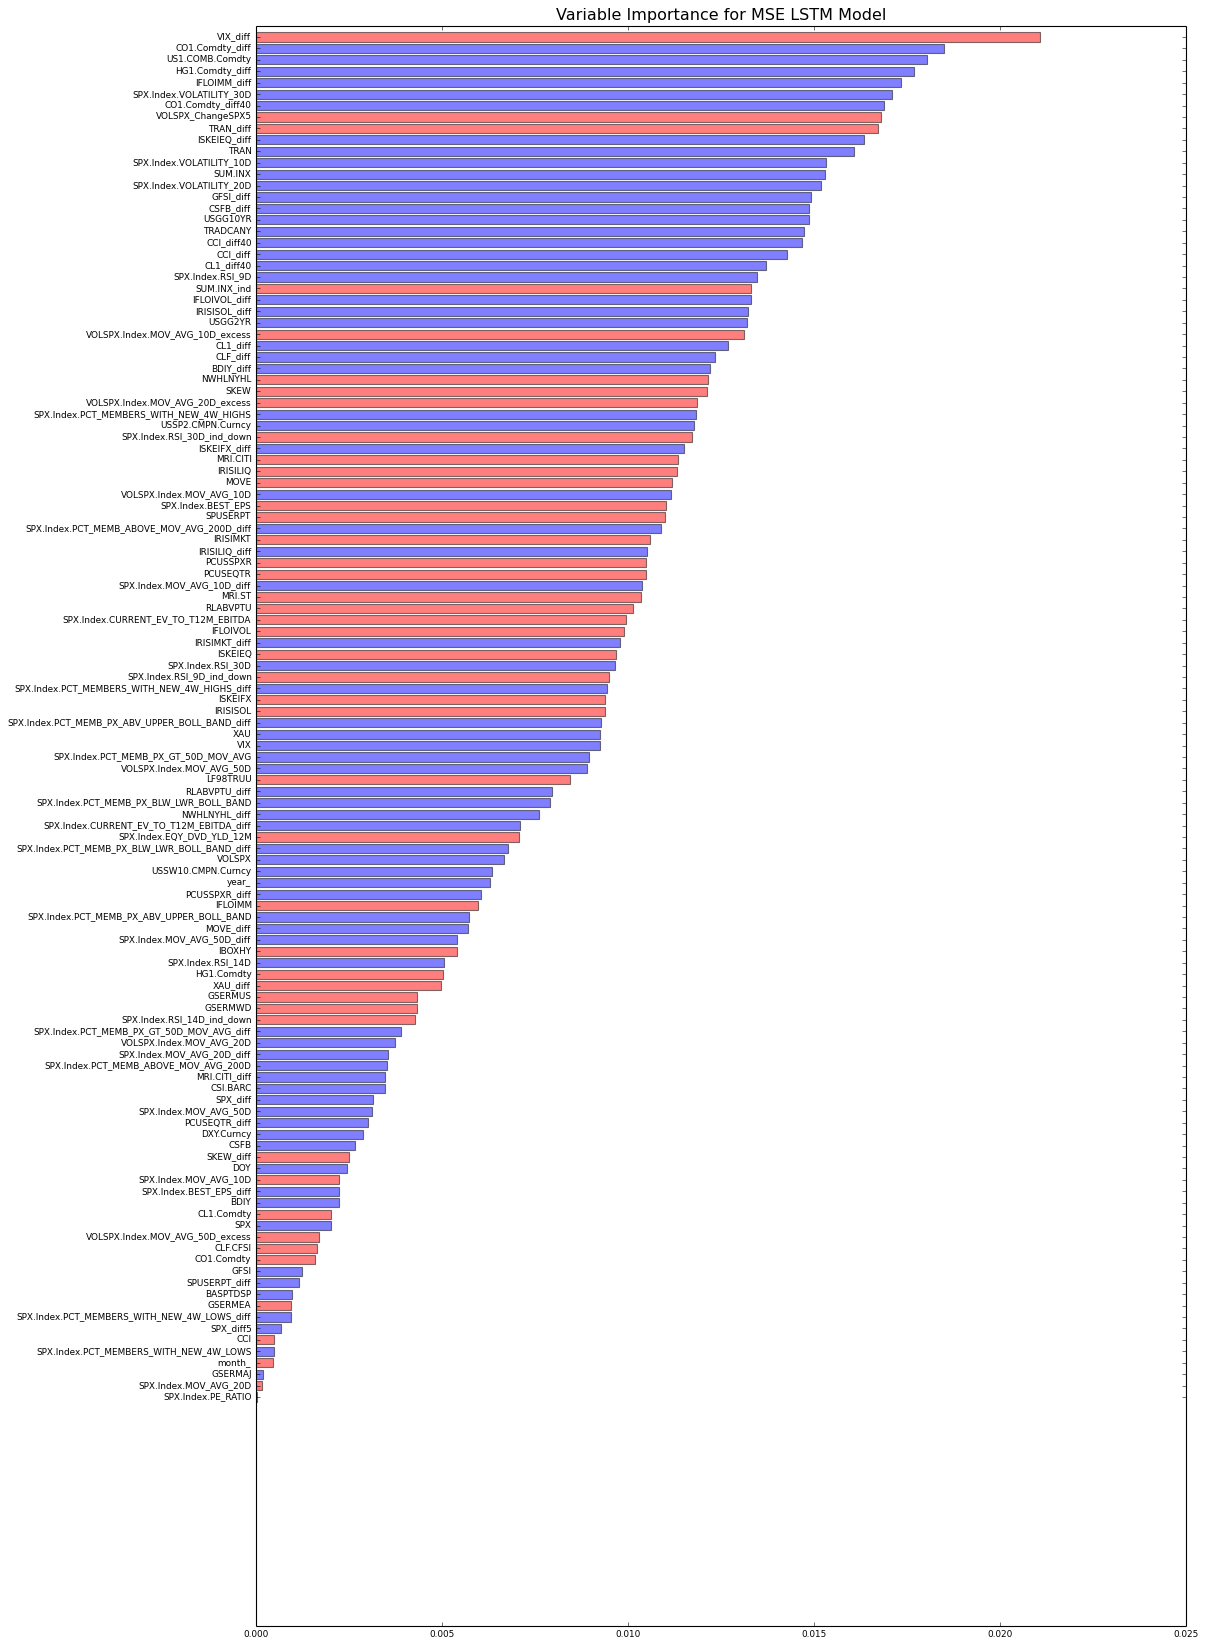

In [56]:
test_matrix = np.zeros((1,20,120))

default_val = model2.predict(test_matrix)

var_imp2 = np.zeros(120)

for i in range(0,120):
    test_matrix[0,:,i] = 1
    testPredict = model2.predict(test_matrix)
    var_imp2[i] = testPredict - default_val

ID = list(dataset)
ID.pop(0)


plt.rcdefaults()

fig = plt.figure(figsize=(15,25))
fig.patch.set_facecolor('white')
objects = np.array(ID) 
y_pos = np.arange(len(objects))
performance = np.array(var_imp2)
performanceabs = [abs(number) for number in performance]
performanceabs,performance, objects = zip(*sorted(zip(performanceabs, performance, objects)))

Colors = np.array(['b']*len(objects))
index = [i for i, e in enumerate(performance) if e < 0]
Colors[index] = ['r']

plt.barh(y_pos, performanceabs, align='center', color = Colors, alpha=0.5)
plt.yticks(y_pos, objects)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.title('Variable Importance for MSE LSTM Model')
 
plt.show()



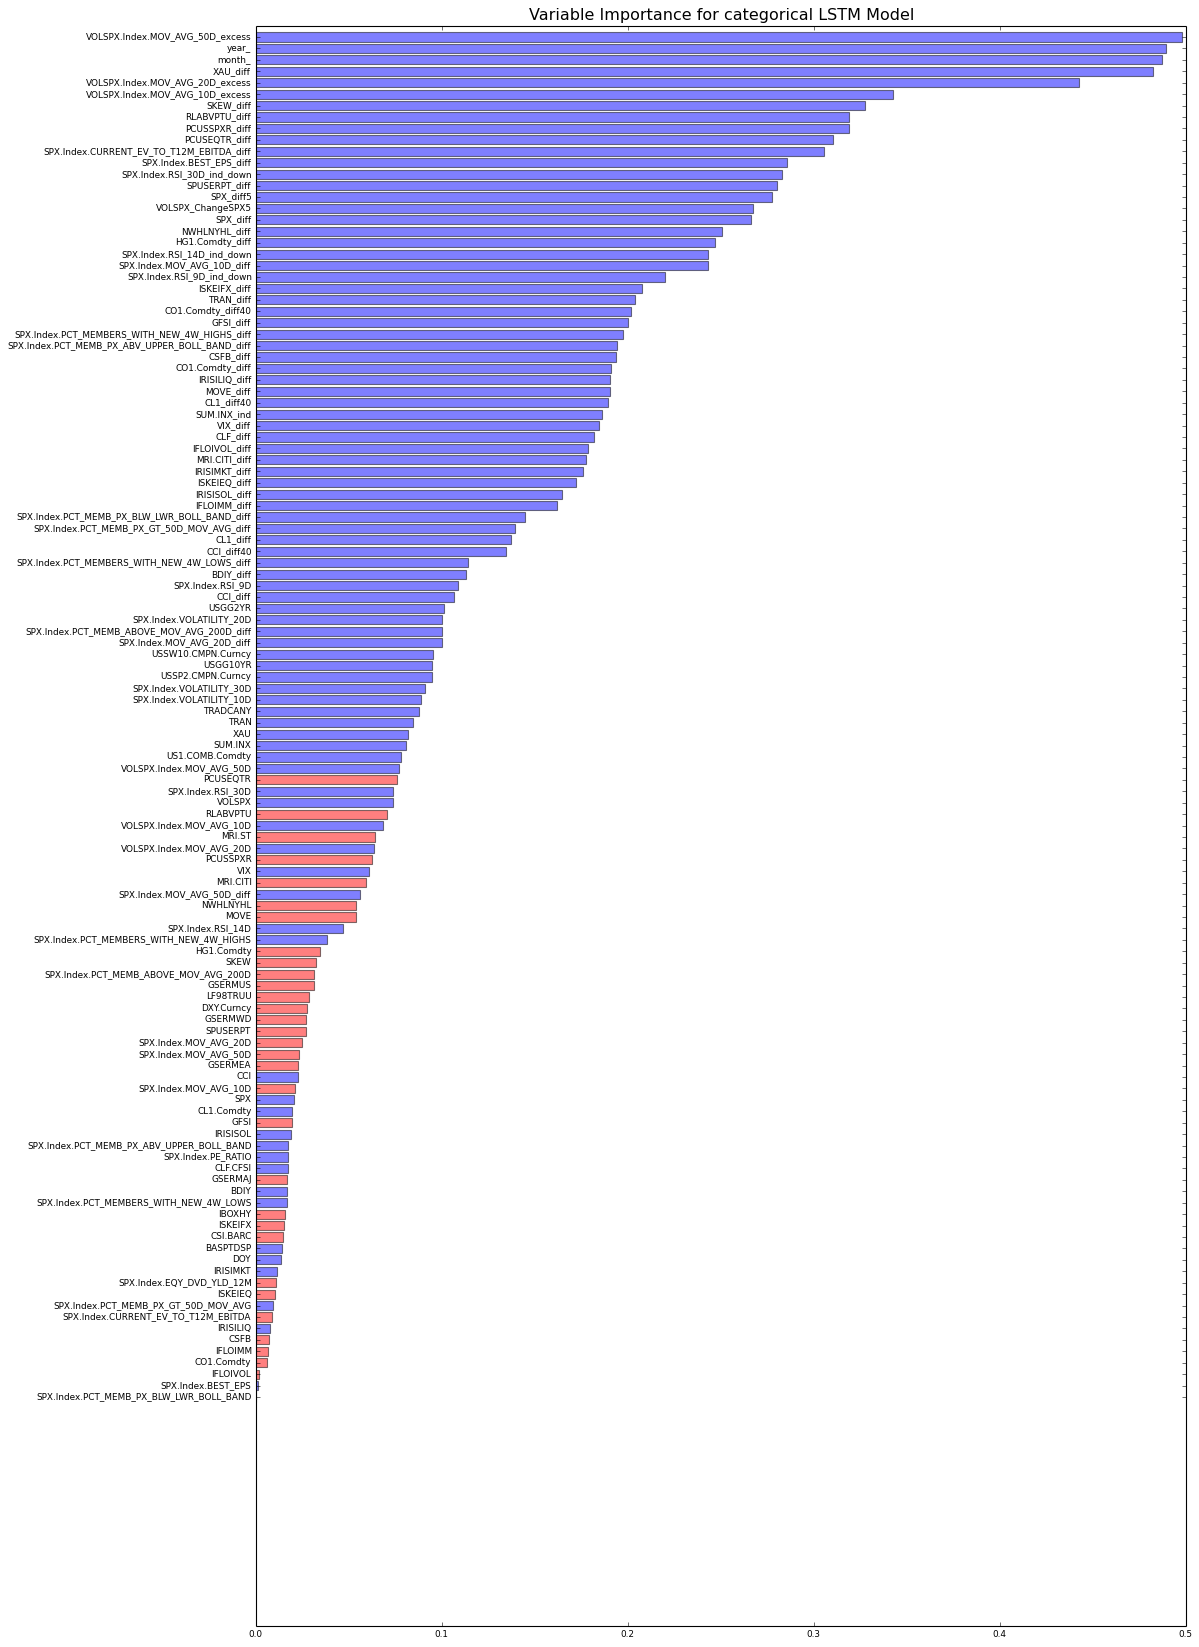

In [54]:
test_matrix = np.zeros((1,20,120))

default_val = model.predict(test_matrix)

var_imp2 = np.zeros(120)

for i in range(0,120):
    test_matrix[0,:,i] = 1
    testPredict = model.predict(test_matrix)
    var_imp2[i] = testPredict - default_val

ID = list(dataset)
ID.pop(0)


plt.rcdefaults()

fig = plt.figure(figsize=(15,25))
fig.patch.set_facecolor('white')
objects = np.array(ID) 
y_pos = np.arange(len(objects))
performance = np.array(var_imp2)
performanceabs = [abs(number) for number in performance]
performanceabs,performance, objects = zip(*sorted(zip(performanceabs, performance, objects)))

Colors = np.array(['b']*len(objects))
index = [i for i, e in enumerate(performance) if e < 0]
Colors[index] = ['r']

plt.barh(y_pos, performanceabs, align='center', color = Colors, alpha=0.5)
plt.yticks(y_pos, objects)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.title('Variable Importance for categorical LSTM Model')
 
plt.show()

Looking at the variable importance graphs between the two models brings some very interesting insight into how the models are working, despite them having similar performance and predictive power.

The variables that drive the most importance in the MSE model (i.e. predicting the level of the forward 20 day SPY return) are more related to fundamental factors, such as changes in the VIX or the changes in the commodity indices. Differences in the transportation index, as well as the level of the transportation index is also very high on the list.

However, the variables that drive importance for the binary model (i.e. predicting whether the SPY will be up or down) are quite different. They are mainly factors that relate to technical trading patterns. We feel this insight to be enlightening as we feel that this shows us that large moves in the market are driven by fundamental drivers, powering the market higher or letting the market sell off in a significant fashion. However, if it were only to be predicting whether the market will go up or down (without taking into account how much), investors and traders alike would turn to technical analysis, to see whether it is overbought or oversold. 

The contrast between the two variable importance graphs, and the way it relates to how the models are constructed provide a very enlightening view of how the LSTM network is starting to be trained much like a human investor, and hopefully without the emotional component.

# Feature selection

As discussed in Section 1, there are multiple ways of performing feature selection. 

The method we employed is a wrapper method using backward elimination, where we first train the data with all the features we have, including feature engineered variables and then iteratively eliminate some of the variables and rerun the models to observe whether or not the features can be removed without impacting the performance of the model. If the model is performing equally well, we will select the model with the least variables. In certain cases, the performance of the model may also improve due to reduced noise and variables in the dataset. 

By performing this iteratively, we were able to eliminate roughly 33% of the bottom importance ranked variables for each of the respective models, without significant impact to model performance. 

Model | Validation Accuracy or Loss | Test Set RMSE | Test Accuracy
---- |------------- |------------- |-------------|
Binary Full Features|85%|n/a|81%
Binary Most Important Features|87%|n/a|82%
MSE Full Features| 0.0007|0.013|84%
MSE Most Important Features|0.0005|0.01355|82%

# Model performance as a trading strategy

In this section, we look at how our model actually could perform as a trading strategy in our testing sample. Note that our model was trained on a 20 day SPY return basis, and hence should be judged based on the 20 day SPY return. We take the SPY 20 day forward return and raise it to the 1/20th power to obtain an estimate for what the daily return should be.

We should not take the actual daily return of the SPY, since our model was not trained on this daily return, but the 20 day return. 

For both our MSE model and the binary model, we convert our prediction into a binary prediction (i.e. whether we predict the market to be down or up), and take a long/short strategy. If it is a long, then the return will simply be the pro-rated daily return. If it is a short prediction, we will take the negative of that return. We cumulate these returns over the test period. We also used a long-only strategy, whereby if we predict the market to be down, we do not hold the SPY and maintain a 0 return for that period. Long short strategies are able to take advantage of correct predictions in a down market, while long only strategies will be able to side-step down moves when predicted correctly. We compared both strategies to the SPY benchmark, which holds the SPY across the test period. 

We notice a strong outperformance in the long/short strategy, followed by the long only strategy, against the SPY benchmark. We observe this significant outperformance for both the binary and the mean squared error LSTM models. 

Model                    | Test Accuracy | Strategy | Cumulative Return over 349 periods
------------------------ |---------:| ----------|-------------------:|
Binary                    |82%     |Long Short|42.0%
Binary                    |82%     |Long Only|31.6%
MSE                       |82%     |Long Short|41.3%
MSE                       |82%     |Long Only|32.3%
Mean                      |~70%     |Buy and Hold|21.5%

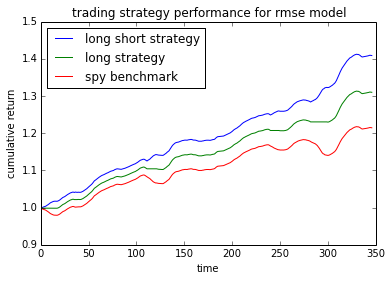

In [44]:
testPredictbinary_short = np.empty(testPredictbinary2.shape[0])
for i in range(0,len(testPredictbinary2)):
    if testPredictbinary2[i] < 0.5:
        testPredictbinary_short[i] = -1
    else:
        testPredictbinary_short[i] = 1

long_return = 1 + np.multiply(testYcut,testPredictbinary2)
long_return = np.power(long_return,0.05)
long_return_cum = np.cumprod(long_return)       
        
short_return = 1 + np.multiply(testYcut,testPredictbinary_short)
short_return = np.power(short_return,0.05)
short_return_cum = np.cumprod(short_return) 

actual_return = 1+testYcut
actual_return = np.power(actual_return,0.05)
spx_return_cum = np.cumprod(actual_return)

plt.plot(short_return_cum)
plt.plot(long_return_cum)
plt.plot(spx_return_cum)
plt.title('trading strategy performance for rmse model')
plt.ylabel('cumulative return')
plt.xlabel('time')
plt.legend(['long short strategy', 'long strategy', 'spy benchmark'], loc='upper left')

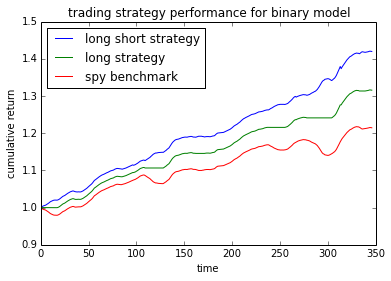

In [37]:
rounded_short = np.empty(len(rounded))
for i in range(0,len(rounded)):
    if rounded[i] < 0.5:
        rounded_short[i] = -1
    else:
        rounded_short[i] = 1

long_return = 1 + np.multiply(testYcut,rounded)
long_return = np.power(long_return,0.05)
long_return_cum = np.cumprod(long_return)       
        
short_return = 1 + np.multiply(testYcut,rounded_short)
short_return = np.power(short_return,0.05)
short_return_cum = np.cumprod(short_return) 

actual_return = 1+testYcut
actual_return = np.power(actual_return,0.05)
spx_return_cum = np.cumprod(actual_return)

plt.plot(short_return_cum)
plt.plot(long_return_cum)
plt.plot(spx_return_cum)
plt.title('trading strategy performance for binary model')
plt.ylabel('cumulative return')
plt.xlabel('time')
plt.legend(['long short strategy', 'long strategy', 'spy benchmark'], loc='upper left')

# Discussion on machine learning algorithms

From the above, we have created an LSTM model to predict the forward 20 day return of the SPY, and have been able to use the strengths of the LSTM which is the memory of long term dependencies and trends in each of the variables to assist in the decision making process. We have explored both a traditional mean squared error approach in predicting the 20 day forward return, as well as framing the problem into a simple up and down prediction of the SPY in the next 20 days. 

We have demonstrated that both models, though each having its own advantages, show a similar performance. 

Traditional neural network models are point-in time-analyses, and struggle to analyze trends in variables across time. They also lack specific memory cells to selectively remember patterns across time. Recurrent neural networks are able to detect patterns across time, however they have trouble remembering patterns over longer periods of time. Technical analysis as well as fundamental analysis requires patterns to be observed over long periods of time. For example, it requires observing whether the technical pattern "completes" itself, or to confirm whether the company or economic fundamentals are truly improving across time. 

We demonstrated as well that if the max timesteps the model were to remember was chosen to be 1 (or 2 or 5), the model was not able to perform as well as it did with 20 timesteps. Since LSTMs are structured based on neural networks, this would give an idea of how a traditional neural network might have performed compared to LSTMs, further highlighting strengths in LSTM models.

Other machine learning algorithms that could potentially perform well with this financial time series dataset would include reinforcement learning algorithms (such as Q learning). Q learning algorithms iteratively try buy or sell techniques (as actions), whilst being rewarded or punished based on the market returns. Via a feedback loop, the machine learning algorithm would start to learn whether to buy or sell in order to maximize the reward. We believe models like this along with LSTMs that capture time series data, could perform well.

# Potential data enhancements

Types of data that can help improve the model could include sector specific data, such as financial sector's earnings, recent performance, net interest margins etc, especially if the sector plays a big role in determining the S&P 500. The weights of each sector's influence would also be beneficial. Technical analysis data points for these sectors could also be beneficial. 

Trend data relating to the demand for call options and put options on the SPY could also be beneficial, especially the trends that lead up to the event. Immediate call and put option demand could impact the SPY in the short term, however, significant demand for call options could push up the SPY over a medium term horizon, and could potentially lead to an overbought situation. 

Non-traditional textual data such as sentiment on news feeds (Twitter is typically full of bots) could help detect market sentiment. Negative sentiment does not necessarily equal sell, as we have demonstrated in the LSTM model, it is the trends that lead up to the event that might cause an oversold situation, which could - based on historical data - allow for a buying opportunity that is objective and relatively unbiased. 

# Next steps

Despite going through many iterations already with the LSTM model, there remains room for improvement in the modeling procedure. For example, more variables and interactions between various variables can be explored and tested.

We could also explore in detail the comparison between traditional recurrent neural networks and LSTMs, to further confirm our hypothesis that the alpha generated in the model could potentially be derived from looking at trends, versus point in time. 

Ensemble methods with other types of machine learning algorithms, such as decision tree based algorithms, can also be explored. We would also like to explore the use of reinforcement learning algorithms along with LSTMs to produce a buy or sell signal based market feedback rewards. 

Furthermore, we would investigate potential methods to further improve the analysis of variable importance via a more structured and formal way for complicated models like LSTMs. Although we believe the methdology we have employed to be relatively robust, a more formulaic approach can be investigated and the results compared and verified.